In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import os
import pickle
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

sys.path.append("../")

In [12]:
from utils import from_pickle, to_pickle

In [13]:
os.makedirs("outputs/", exist_ok=True)

In [14]:
mpl.rcParams["grid.linestyle"] = ":"
mpl.rcParams["axes.grid"] = True

In [15]:
PREPROC_DIR = (
    "D:/03 UofA/02 Code/MPM/QUEST Northwest/Workflow/Preprocessing/outputs/"
)

In [16]:
X_train, X_test, y_train, y_test = from_pickle(
    PREPROC_DIR + "train_test_set.pkl"
)
scalers = from_pickle(PREPROC_DIR + "scalers.pkl")
pred_tensor = from_pickle(PREPROC_DIR + "prediction_tensor.pkl")

print(X_train.shape)
print(y_train.shape)

(1387, 100, 100, 45)
(1387,)


In [17]:
centroids, all_nodes = from_pickle(PREPROC_DIR + "centroids.pkl")
grid_spec = from_pickle(PREPROC_DIR + "grid_spec.pkl")

In [18]:
input_shape = (None, 100, 100, 45)

# Load Augmented Data

In [19]:
y_train = tf.one_hot(y_train, depth=int(2))
y_test = tf.one_hot(y_test, depth=int(2))

In [20]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [21]:
train_ds, test_ds

(<TensorSliceDataset shapes: ((100, 100, 45), (2,)), types: (tf.float64, tf.float32)>,
 <TensorSliceDataset shapes: ((100, 100, 45), (2,)), types: (tf.float64, tf.float32)>)

In [22]:
print(len(train_ds), len(test_ds))

1387 347


# Resize
- Resize images for 227x227 pixel AlexNet input
- Augment training examples to diversify training set
- https://www.tensorflow.org/tutorials/images/data_augmentation#data_augmentation_2

In [23]:
IMG_SIZE = 227
BATCH_SIZE = 32
SEED = 3654
N_CHANNELS = train_ds.element_spec[0].shape[-1]
AUTOTUNE = tf.data.AUTOTUNE

In [24]:
resize_and_rescale = tf.keras.Sequential([layers.Resizing(IMG_SIZE, IMG_SIZE)])
resize_and_rescale.build(input_shape)
resize_and_rescale.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 227, 227, 45)      0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


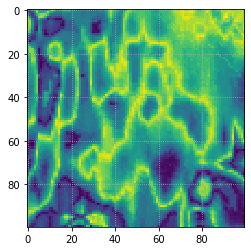

In [25]:
c = 11
image, label = next(iter(train_ds))
_ = plt.imshow(image[..., c])

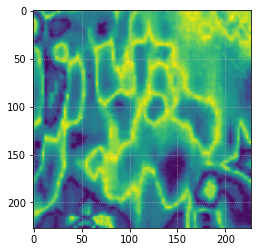

In [26]:
result = resize_and_rescale(image)
_ = plt.imshow(result[..., c])

In [29]:
def prepare_ds(ds, shuffle=False, augment=False):
    ds = ds.map(
        lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE
    )
    if shuffle:
        ds = ds.shuffle(tf.data.experimental.cardinality(ds).numpy())
    ds = ds.batch(BATCH_SIZE)
    if augment:
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE,
        )
    return ds.prefetch(buffer_size=AUTOTUNE)

In [30]:
train_ds = prepare_ds(train_ds, shuffle=True, augment=False)
test_ds = prepare_ds(test_ds)

In [31]:
train_ds, test_ds

(<PrefetchDataset shapes: ((None, 227, 227, 45), (None, 2)), types: (tf.float32, tf.float32)>,
 <PrefetchDataset shapes: ((None, 227, 227, 45), (None, 2)), types: (tf.float32, tf.float32)>)

# AlexNet
- https://paperswithcode.com/paper/imagenet-classification-with-deep
- https://github.com/mikechen66/AlexNet_TensorFlow2.0-2.3/blob/master/alexnet.py
- https://github.com/yangna815/Mineral-Prospectivity-Prediction-Convolutional-Neural-Networks

In [32]:
model = Sequential(
    [
        # No.1 Convolutional Layer: (227- 11 + 2 * 0) / 4 + 1 = 55
        layers.Conv2D(
            filters=96,
            kernel_size=(11, 11),
            strides=(4, 4),
            activation="relu",
            input_shape=(IMG_SIZE, IMG_SIZE, N_CHANNELS),
            kernel_initializer="GlorotNormal",
            name="CONV1",
        ),
        # Max Pooling: (55- 3 + 2 * 0) / 2 + 1 = 27
        layers.MaxPool2D(
            pool_size=(3, 3), strides=(2, 2), padding="valid", name="MAXPOOL1"
        ),
        # No.2 Conv Layer: (27- 5 + 2 * 2) / 1 + 1 = 27
        layers.Conv2D(
            filters=256,
            kernel_size=(5, 5),
            strides=(1, 1),
            activation="relu",
            padding="same",
            kernel_initializer="GlorotNormal",
            name="CONV2"
            # add kernel regularizer here?
        ),
        # Max Pooling: (27-  3 + 2 * 0) / 2 + 1 = 13
        layers.MaxPool2D(
            pool_size=(3, 3), strides=(2, 2), padding="valid", name="MAXPOOL2"
        ),
        # No.3 Conv Layer: (13 - 3 + 2 * 1) / 1 + 1 = 13
        layers.Conv2D(
            filters=384,
            kernel_size=(3, 3),
            strides=(1, 1),
            activation="relu",
            padding="same",
            kernel_initializer="GlorotNormal",
            name="CONV3",
        ),
        # No.4 Conv Layer: (13 - 3 + 2 * 1) / 1 + 1 = 13
        layers.Conv2D(
            filters=384,
            kernel_size=(3, 3),
            strides=(1, 1),
            activation="relu",
            padding="same",
            kernel_initializer="GlorotNormal",
            name="CONV4",
        ),
        # No.5 Conv Layer: (13 - 3 + 2 * 1) / 1 + 1 = 13
        layers.Conv2D(
            filters=256,
            kernel_size=(3, 3),
            strides=(1, 1),
            activation="relu",
            padding="same",
            kernel_initializer="GlorotNormal",
            name="CONV5",
        ),
        # Max Pooling: (13 - 3 + 2 * 0) / 2 + 1 =  6
        layers.MaxPool2D(
            pool_size=(3, 3), strides=(2, 2), padding="valid", name="MAXPOOL3"
        ),
        layers.Flatten(),
        # No.6 FC Layer
        layers.Dense(4096, activation="relu", name="FC1"),
        layers.Dropout(0.5),
        # No.7 FC Layer
        layers.Dense(4096, activation="relu", name="FC2"),
        layers.Dropout(0.5),
        # No.8 FC Layer
        layers.Dense(1000, activation="relu", name="FC3"),
        layers.Dense(2, activation="softmax", name="FC4"),
    ]
)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"],
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv2D)              (None, 55, 55, 96)        522816    
                                                                 
 MAXPOOL1 (MaxPooling2D)     (None, 27, 27, 96)        0         
                                                                 
 CONV2 (Conv2D)              (None, 27, 27, 256)       614656    
                                                                 
 MAXPOOL2 (MaxPooling2D)     (None, 13, 13, 256)       0         
                                                                 
 CONV3 (Conv2D)              (None, 13, 13, 384)       885120    
                                                                 
 CONV4 (Conv2D)              (None, 13, 13, 384)       1327488   
                                                                 
 CONV5 (Conv2D)              (None, 13, 13, 256)      

In [33]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds,
    workers=7,
    use_multiprocessing=True,
)
model.save("./outputs/model_trained.tf")
to_pickle("./outputs/model_history.pkl", history.history)

Epoch 1/10
44/44 [==============================] - 59s 1s/step - loss: 1.0025 - accuracy: 0.5306 - val_loss: 0.6934 - val_accuracy: 0.5101
Epoch 2/10
44/44 [==============================] - 58s 1s/step - loss: 0.6877 - accuracy: 0.5588 - val_loss: 0.7038 - val_accuracy: 0.5101
Epoch 3/10
44/44 [==============================] - 58s 1s/step - loss: 0.6872 - accuracy: 0.5588 - val_loss: 0.6984 - val_accuracy: 0.5101
Epoch 4/10
44/44 [==============================] - 58s 1s/step - loss: 0.6869 - accuracy: 0.5588 - val_loss: 0.6977 - val_accuracy: 0.5101
Epoch 5/10
44/44 [==============================] - 58s 1s/step - loss: 0.6867 - accuracy: 0.5588 - val_loss: 0.6956 - val_accuracy: 0.5101
Epoch 6/10
44/44 [==============================] - 58s 1s/step - loss: 0.6872 - accuracy: 0.5588 - val_loss: 0.6971 - val_accuracy: 0.5101
Epoch 7/10
44/44 [==============================] - 59s 1s/step - loss: 0.6858 - accuracy: 0.5588 - val_loss: 0.6949 - val_accuracy: 0.5101
Epoch 8/10
44/44 [==

INFO:tensorflow:Assets written to: ./outputs/model_trained.tf\assets


INFO:tensorflow:Assets written to: ./outputs/model_trained.tf\assets


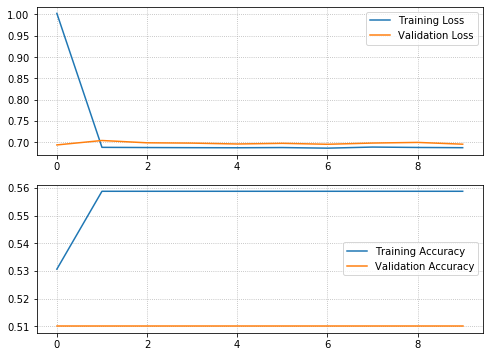

In [34]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))

axes[0].plot(model.history.history["loss"], label="Training Loss")
axes[0].plot(model.history.history["val_loss"], label="Validation Loss")

axes[1].plot(model.history.history["accuracy"], label="Training Accuracy")
axes[1].plot(
    model.history.history["val_accuracy"], label="Validation Accuracy",
)
for ax in axes:
    ax.legend()

# Prediction

In [35]:
model = tf.keras.models.load_model("./outputs/model_trained.tf")

In [36]:
pred_ds = resize_and_rescale(pred_tensor)

In [37]:
pred = model.predict(pred_ds, workers=7, use_multiprocessing=True)

In [38]:
grid = np.concatenate((all_nodes, np.full((len(all_nodes), 2), np.nan)), axis=1)
mask = (grid[:, 2] == 0) & (grid[:, 3] == 1)
np.putmask(grid[:, -1], mask, pred)

In [39]:
def coord_to_2D_idx(x, y, xmin, ymin, xsize, ysize):
    """convert (x, y) to (ix, iy) with top left origin"""
    ix = (np.ceil((x - xmin) / xsize + 0.5) - 1).astype(int)
    iy = (np.ceil((y - ymin) / ysize + 0.5) - 1).astype(int)
    return ix, iy

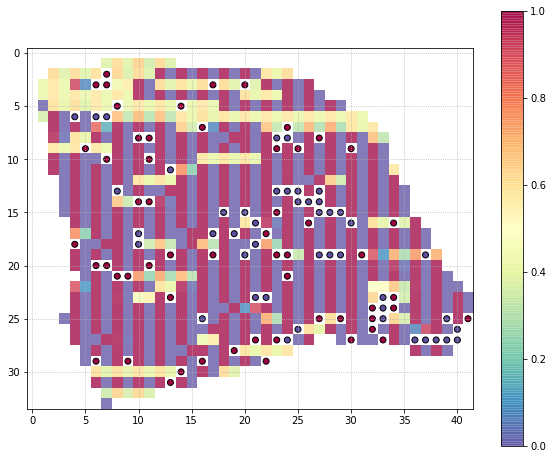

In [40]:
fig, ax = plt.subplots(figsize=(10, 8))
cmap = "Spectral_r"
training = centroids[centroids[:, 2] > 0]
im = ax.imshow(
    grid[:, -1].reshape(grid_spec["ny"], grid_spec["nx"]), cmap=cmap, alpha=0.75
)
ax.scatter(
    *coord_to_2D_idx(
        training[:, 0],
        training[:, 1],
        0,
        0,
        grid_spec["xsize"],
        grid_spec["ysize"],
    ),
    c=training[:, 2],
    cmap=cmap,
    ec="k"
)
_ = plt.colorbar(im, ax=ax)